In [1]:
import sys
sys.path.append('src/features')

In [94]:
import pandas as pd
import numpy as np

from datetime import timedelta
from datetime import datetime

import re

import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
import customplots
from customplots import target_features_plot, grid_serach_dt, col_import_plot

from dates_processor import *

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Train data
data=pd.read_csv('data/mimic_train.csv')
print(data.shape)
data.head()

(20885, 44)


,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654


In [6]:
# Test dataset (to produce predictions)
data_test=pd.read_csv('data/mimic_test_death.csv')
print(data_test.shape)
data_test.sort_values('icustay_id').head()

(5221, 39)


,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
4930,93535,121562,200011,56.0,82.0,71.205128,123.0,185.0,156.411765,37.0,...,2188-08-05 20:27:00,-64881.43517,EMERGENCY,Medicare,JEWISH,SINGLE,WHITE,ASTHMA;COPD EXACERBATION,49322,MICU
1052,30375,177945,200044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2135-07-07 16:13:00,-46540.62661,EMERGENCY,Medicare,CATHOLIC,WIDOWED,WHITE,HEAD BLEED,85220,SICU
3412,73241,149216,200049,54.0,76.0,64.833333,95.0,167.0,114.545455,33.0,...,2118-08-14 22:27:00,-38956.85890,EMERGENCY,Private,JEWISH,MARRIED,WHITE,HEPATIC ENCEPHALOPATHY,5722,MICU
1725,99052,129142,200063,85.0,102.0,92.560976,91.0,131.0,108.365854,42.0,...,2141-03-09 23:19:00,-47014.25437,EMERGENCY,Medicaid,NOT SPECIFIED,SINGLE,UNKNOWN/NOT SPECIFIED,TYPE A DISSECTION,44101,CSRU
981,51698,190004,200081,82.0,133.0,94.323529,86.0,143.0,111.093750,47.0,...,2142-02-23 06:56:00,-47377.26087,EMERGENCY,Medicare,OTHER,MARRIED,PORTUGUESE,PULMONARY EMBOLISM,41519,CCU


In [7]:
# I see that there are some columns in training not in test, let's keep the same in both
print([col for col in data.columns if col not in data_test.columns])

['HOSPITAL_EXPIRE_FLAG', 'DOD', 'DISCHTIME', 'DEATHTIME', 'LOS']


In [8]:
data.drop(['DOD', 'DISCHTIME', 'DEATHTIME', 'LOS'], axis = 1, inplace=True)
print(data.shape)
print(data_test.shape)

(20885, 40)
(5221, 39)


## Data exploration and feature engineering

### Target variable

0.11228154177639454
0    18540
1     2345
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64


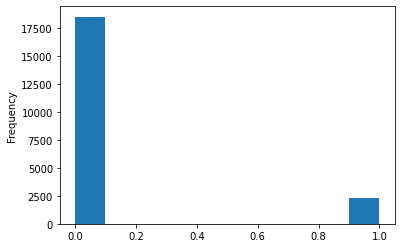

In [9]:
# Target variable
data['HOSPITAL_EXPIRE_FLAG'].plot(kind='hist')
print(data['HOSPITAL_EXPIRE_FLAG'].mean())
print(data['HOSPITAL_EXPIRE_FLAG'].value_counts())

In [31]:
# Join both train and test
data['from'] = 'train'
data_test['from'] = 'test'
df = pd.concat([data, data_test], axis = 0)
df.reset_index(inplace=True, drop=True)
print(df.shape)

(26106, 41)


In [32]:
### Adjusting the format of the dates
df['DOB'] = pd.to_datetime(df['DOB'])
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])

In [33]:
# Adjust days using diff
df['Diff_days'] = df['Diff'].apply(np.floor).apply(lambda x: pd.Timedelta(x, unit='D'))
df['DOB'] = df['DOB'] + df['Diff_days']
df['ADMITTIME'] = df['ADMITTIME'] + df['Diff_days']
print(df['ADMITTIME'].dt.year.value_counts())
print(df['DOB'].dt.year.value_counts())

2008    6548
2009    5211
2010    5180
2011    5158
2012    4000
2007       9
Name: ADMITTIME, dtype: int64
1944    660
1946    605
1945    605
1947    597
1943    594
       ... 
1704     14
1994      8
1701      5
1995      4
1996      1
Name: DOB, Length: 90, dtype: int64


In [34]:
# Adjust the hours
df['Diff_h'] = ((np.abs(df['Diff']) % 1) * -24).round() # Number of hours to rest from the date according to the decimal points of Diff
df['Diff_h'] = df['Diff_h'].apply(lambda x: pd.Timedelta(x, unit='h'))
print(df['ADMITTIME'])
df['ADMITTIME'] = df['ADMITTIME'] + df['Diff_h']
print(df['ADMITTIME'])

0       2008-06-15 10:35:00
1       2010-12-26 22:34:00
2       2010-11-10 23:04:00
3       2011-09-26 08:00:00
4       2008-09-12 02:02:00
                ...        
26101   2008-05-31 11:01:00
26102   2008-04-03 10:45:00
26103   2009-12-17 04:04:00
26104   2011-11-22 07:15:00
26105   2011-08-20 07:15:00
Name: ADMITTIME, Length: 26106, dtype: datetime64[ns]
0       2008-06-14 15:35:00
1       2010-12-26 18:34:00
2       2010-11-10 00:04:00
3       2011-09-25 23:00:00
4       2008-09-11 08:02:00
                ...        
26101   2008-05-30 20:01:00
26102   2008-04-03 08:45:00
26103   2009-12-16 06:04:00
26104   2011-11-22 04:15:00
26105   2011-08-19 16:15:00
Name: ADMITTIME, Length: 26106, dtype: datetime64[ns]


In [53]:
# Using my processor for the creation of year, month, day , weekday and hour from a date column
dates_p = DatesPreprocessor()
df_d = dates_p.preprocess(df, ['ADMITTIME'])

In [54]:
# Delete columns I don't need
df_d = df_d.drop(['Diff', 'Diff_days', 'Diff_h'], axis=1)
df_d.columns

Index(['HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id', 'icustay_id',
       'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'DOB', 'ADMITTIME', 'ADMISSION_TYPE',
       'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS',
       'ICD9_diagnosis', 'FIRST_CAREUNIT', 'from', 'ADMITTIME_year',
       'ADMITTIME_month', 'ADMITTIME_day', 'ADMITTIME_weekday',
       'ADMITTIME_hour'],
      dtype='object')

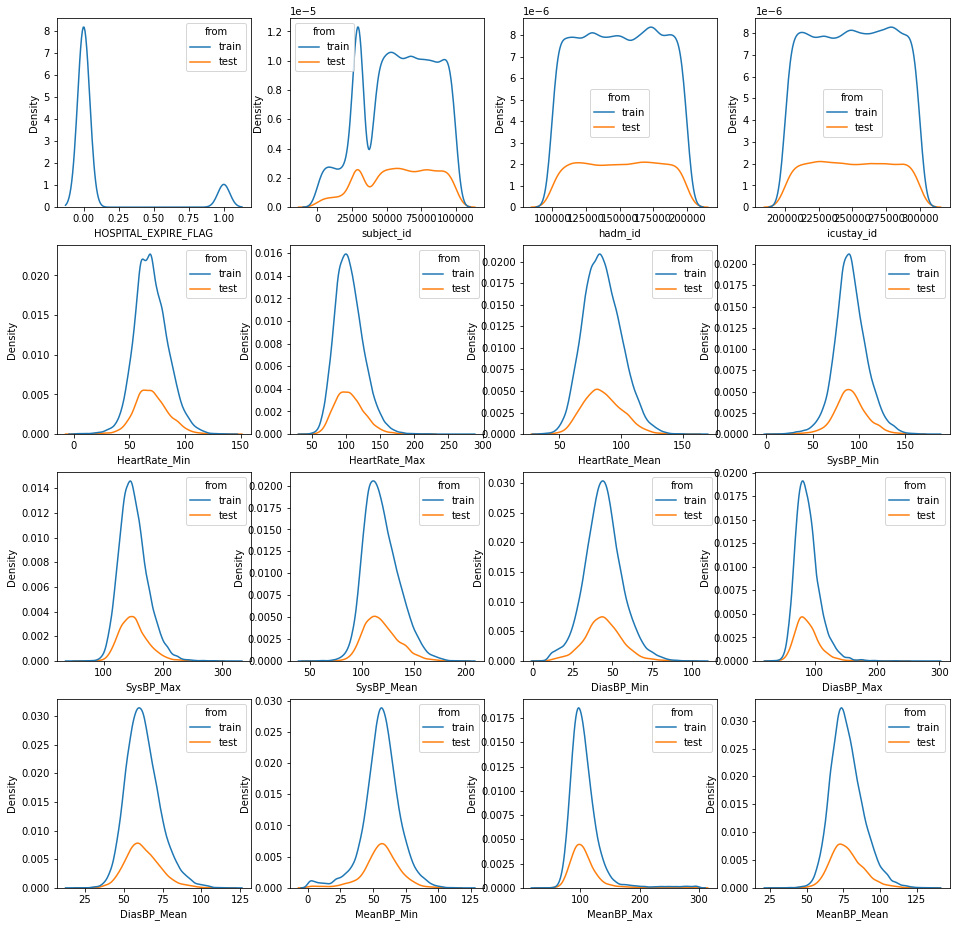

In [57]:
# Plot distribution of numeric features for train and test
target_features_plot(df_d, 'from', df_d.select_dtypes('number').columns[:16], 'density')

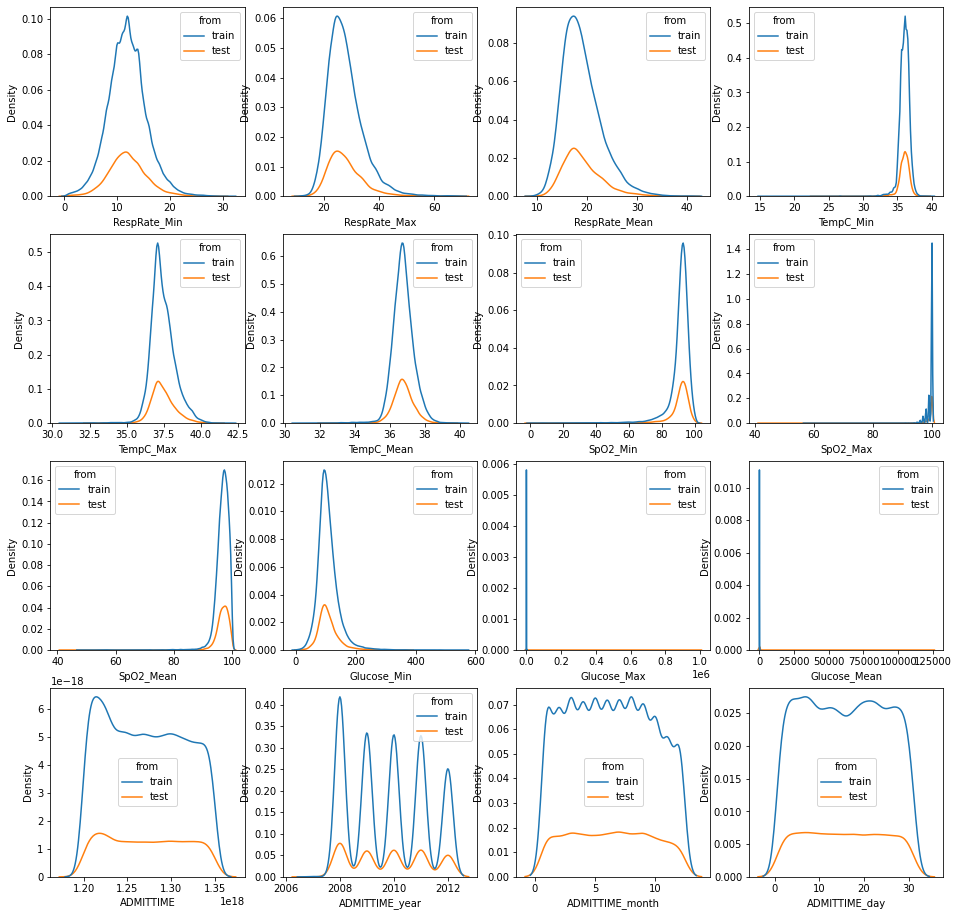

In [59]:
target_features_plot(df_d, 'from', df_d.select_dtypes('number').columns[16:32], 'density')

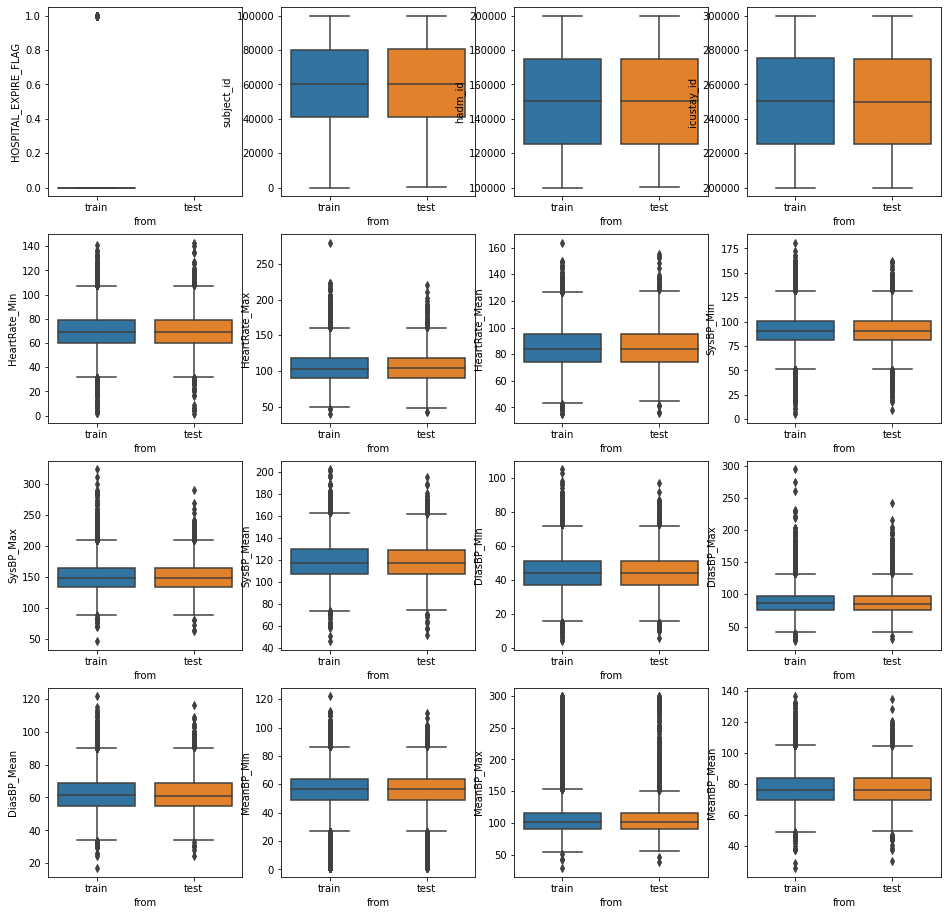

In [60]:
target_features_plot(df_d, 'from', df_d.select_dtypes('number').columns[:16], 'boxplot')

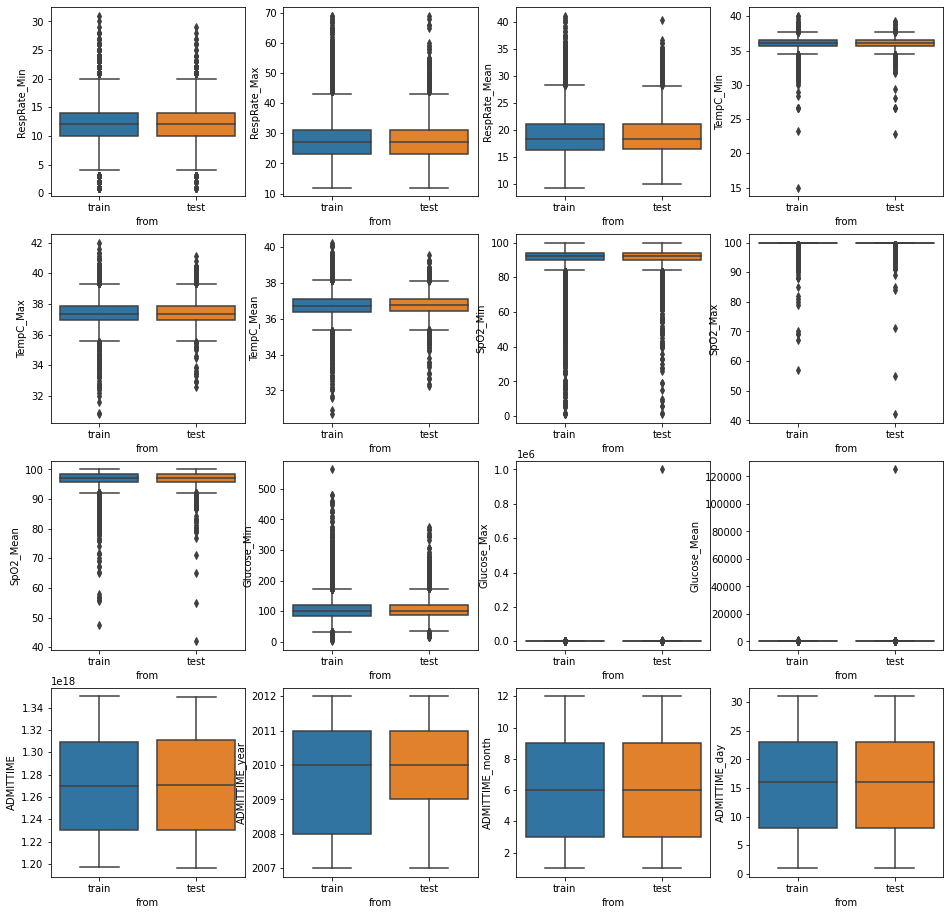

In [62]:
target_features_plot(df_d, 'from', df_d.select_dtypes('number').columns[16:32], 'boxplot')

The distribution of the features is similar in both test and train data

### ICD9_diagnosis

Seeing the List of ICD-9 codes I realize that many ICD9 are wrong https://en.wikipedia.org/wiki/List_of_ICD-9_codes

It's a 3 digits of letter + 3 digits code

In [126]:
def fix_ICD9(text):
    text = re.sub(r'^0', r'', text) # replace those that start with ceros
    text = re.sub(r'(\d{3})(\d{2})', r'\1.\2', text) # include . when it has 5 digits
    text = re.sub(r'(\d{3})(\d{1})', r'\1.\2', text) # include . when it has 4 digits
    text = re.sub(r'(E)(\d+)', r'19\2', text) # replace E with 19
    text = re.sub(r'(V)(\d+)', r'29\2', text) # replace V with 29
    return text
    
df_d['ICD9_diagnosis2'] = df_d['ICD9_diagnosis'].apply(fix_ICD9).astype(float)

In [147]:
df_d['ICD9_L1'] = pd.cut(x = df_d['ICD9_diagnosis2'], 
                         bins = [0, 139, 239, 279, 289, 319, 389, 459, 519, 579, 629, 679, 709, 739, 759, 779, 799, 999, df_d['ICD9_diagnosis2'].max()], 
                         labels=False)
df_d[['ICD9_L1', 'ICD9_diagnosis2']].head()

,ICD9_L1,ICD9_diagnosis2
0,8,578.90
1,8,530.13
2,8,569.83
3,8,553.30
4,8,562.11


    ICD9_L1  HOSPITAL_EXPIRE_FLAG
5         5              0.222550
11       11              0.155172
1         1              0.151205
7         7              0.146542
17       17              0.139241
0         0              0.118143
8         8              0.100881
9         9              0.093541
6         6              0.093335
16       16              0.092526
3         3              0.088235
15       15              0.054393
2         2              0.037338
12       12              0.024845
4         4              0.014925
10       10              0.000000
13       13              0.000000
14       14              0.000000


<AxesSubplot:xlabel='ICD9_L1', ylabel='HOSPITAL_EXPIRE_FLAG'>

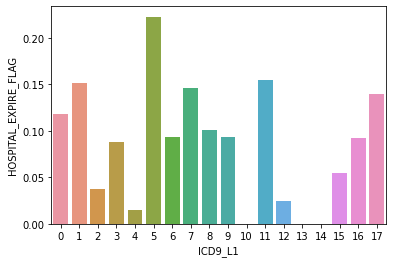

In [164]:
data_res = df_d.groupby('ICD9_L1').mean()['HOSPITAL_EXPIRE_FLAG'].to_frame().reset_index()
print(data_res.sort_values(by='HOSPITAL_EXPIRE_FLAG', ascending=False))
#data_res['HOSPITAL_EXPIRE_FLAG'].plot(kind='hist')
sns.barplot(x='ICD9_L1', y = 'HOSPITAL_EXPIRE_FLAG', data = data_res)

In [82]:
#df_d['ICD9_diagnosis']
#df_d[df_d['DIAGNOSIS'].str.match('SEVERE')]['DIAGNOSIS']
df_d[df_d['DIAGNOSIS'].str.match('BRAIN')]['DIAGNOSIS']

43       BRAIN TUMOR/SDA
135           BRAIN MASS
209           BRAIN MASS
264      BRAIN TUMOR/SDA
367           BRAIN MASS
              ...       
25333         BRAIN MASS
25405     BRAIN MASS/SDA
25492        BRAIN BLEED
25691         BRAIN MASS
25999        BRAIN TUMOR
Name: DIAGNOSIS, Length: 274, dtype: object

In [87]:
df_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26106 entries, 0 to 26105
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   HOSPITAL_EXPIRE_FLAG  20885 non-null  float64       
 1   subject_id            26106 non-null  int64         
 2   hadm_id               26106 non-null  int64         
 3   icustay_id            26106 non-null  int64         
 4   HeartRate_Min         23374 non-null  float64       
 5   HeartRate_Max         23374 non-null  float64       
 6   HeartRate_Mean        23374 non-null  float64       
 7   SysBP_Min             23347 non-null  float64       
 8   SysBP_Max             23347 non-null  float64       
 9   SysBP_Mean            23347 non-null  float64       
 10  DiasBP_Min            23345 non-null  float64       
 11  DiasBP_Max            23345 non-null  float64       
 12  DiasBP_Mean           23345 non-null  float64       
 13  MeanBP_Min      